# Reference. YOLO (You Only Look Once)

- **<font color="ff6f61">YOLO(You Only Look Once)</font>**가 무엇일까요? 이름을 보면 **한 번만 봐도 된다**는 것을 강조하고 있습니다. 
- 왜 '한 번'을 강조했을 지 이후에 이론을 통해서 알아보도록 할게요!
- YOLO는 주어진 이미지에서 Bounding Box(BBox)의 위치와 Classification을 한번에 수행하는 사물 인식(Object Detection) 모델입니다.
    - BBox : 윤곽선(Bounding Box)라고 하며 Object를 인식해서 어떤 물체가 이미지 내에서 어떻게 위치하고 있는 지를 알려줍니다.  
BBox $(x, y, w, h, c)$ : 좌표 위치 $(x, y)$와 그 박스의 너비와 높이 $(w, h)$, 그리고 어떤 클래스인지 $c$를 통해서 object를 나타내주게 될 것입니다.

# 사물 인식 (Object Detection) vs 이미지 분할(Image Segmentation)

## 개념 정의

사물 인식(Object Detection) 모델은 여러 객체들이 존재하는 이미지 내에서 각각의 객체(Object)가 있는 **(1) 위치**, 
객체를 포함하는 바운딩 박스와 그 박스 내의 **(2) 객체에 대한 클래스를 분류**해주는 역할을 합니다. 
- (1) 위치를 찾아야 하기 때문에 Regression 문제를 풀게 될 것이고
- (2) 클래스 분류를 해야하기 때문에 Classification 문제도 동시에 풀어내야 합니다.  

<br>컴퓨터 비전 기술의 Semantic Segmentation, Instance segmentation과는 과연 어떻게 다를까요? 

<br>이들과의 차이점이라고 한다면, 이들은 이미지의 각 픽셀 마다 레이블이 부여되어 객체별로 색칠이 된 것 같은 이미지를 가지고 있습니다.  
다음 그림을 통해서 이들의 차이점을 다시 한번 알아보겠습니다.

<img src="https://miro.medium.com/max/3272/1*iT3zaWgqiOd18vtiEOWEEw.png" width =800>

그림에서 사물 인식(Object Detection)은 바운딩 박스(BBOX)의 위치와 레이블을 가지고 있습니다.  
즉, 색칠되는 레이블이 아니라 각각의 객체마다의 레이블을 가지고 있습니다. 

<br>YOLO는 기존의 이미지 분할 기법, 다른 사물 인식 모델인 R-CNN 계열과 비교 했을 때, 비슷한 성능을 기준으로 훨씬 빠른 시행 속도(inference time)를 자랑합니다. 

- 이 속도의 차이는 어디에서 올까요? 
 - YOLO : Single stage detector
 - R-CNN : Two stage detector

<br>다른 표현으로는 1 stage detector, 2 stage detector라고도 부릅니다. YOLO의 경우 후보 영역을 찾는 과정과 검출/분류 과정이 한 번에 이뤄지기 때문입니다.  
 시행 속도가 빠르기 때문에, 실시간 판단을 요하는 자율 주행과 같은 도메인에서 활용할 수 있는 것입니다. 

<br>이번 시간에는 YOLO의 동작 원리에 대해서 이해하고 버전이 높아질 수록 어떤 특징들을 담고 있는지 공부해두면,  
실제로 각 모델을 직접 개발해서 쓰진 않겠지만, 모델을 활용할 때 더 많은 인사이트를 얻을 수 있습니다. 

<img src="https://dagshub.com/blog/content/images/2022/06/image-2.png" width=600>

먼저 사물 인식 모델의 데이터와 레이블을 한번 살펴봅시다.

## 샘플 데이터 : PascalVOC, RoadSign

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/road147.png">

샘플 이미지를 표현한 레이블 정보입니다. 이미지의 이름, 크기, 바운딩 박스의 위치정보 등을 포함하고 있습니다.


```
<annotation>
    <folder>images</folder>
    <filename>road147.png</filename>
    <size>
        <width>400</width>
        <height>228</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>crosswalk</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>129</xmin>
            <ymin>27</ymin>
            <xmax>259</xmax>
            <ymax>161</ymax>
        </bndbox>
    </object>
</annotation>
```

모델을 직접 구현하는 것도 좋겠지만, 요즘같은 오픈 소스 시대에는 모델을 잘 알고 적소에 활용하는 것이 중요합니다. 

## 오픈소스 모델 구현해보기

이제부터는 YOLO 모델이 어떻게 생겨나게 되었는지, 버전별로 어떤 발전과 기여(contribution) 했는지를 알아봅시다.  
<br>모델을 불러오는 것은 상당히 쉽습니다. 
여러분이 앞으로 만나게될 세상에서는 모델들을 쉽게 사용할 수 있도록 공유된 세상입니다.  
github 주소만 알고, `Readme.md`를 잘 읽고 시키는 대로만 해도 쉽게 모델을 구현할 수 있습니다.  

<br>간단하게 colab에서 모델을 구현해 봅시다. 
비슷한 방법으로 여러분의 local에서도 구현할 수 있습니다. 

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15378, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15378 (delta 4), reused 1 (delta 0), pack-reused 15368
Receiving objects: 100% (15378/15378), 14.34 MiB | 18.41 MiB/s, done.
Resolving deltas: 100% (10516/10516), done.


<br>다운로드 된 폴더의 내용을 살펴봅니다.  
1.   README.md에 사용법이 나와 있습니다. 
2.   설명대로 우리는 `detect.py`라는 파일을 이용해서 인퍼런스를 수행할 것입니다. 
3.   친절하게 샘플 데이터를 제공하고 있고, `detect.py`에는 파서까지 잘 되어있어서, 우리가 사용할 이미지를 넣을 때에는 `--source 'foler/filename'`을 이용하면 바로 인퍼런스를 해볼 수 있습니다.

In [2]:
!ls yolov5

benchmarks.py	 data	     LICENSE	      requirements.txt	tutorial.ipynb
CITATION.cff	 detect.py   models	      segment		utils
classify	 export.py   README.md	      setup.cfg		val.py
CONTRIBUTING.md  hubconf.py  README.zh-CN.md  train.py


<br>동일한 환경을 맞춰주는 작업을 수행합니다. 

In [3]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.9 MB/s eta 0:00:00


<br>바로 인퍼런스! 참 쉽죠!

In [4]:
!python yolov5/detect.py --source 'yolov5/data/images/bus.jpg'

detect: weights=yolov5/yolov5s.pt, source=yolov5/data/images/bus.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-136-g71244ae Python-3.9.16 torch-2.0.0+cu118 CPU

100% 14.1M/14.1M [00:00<00:00, 135MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 411.4ms
Speed: 4.4ms pre-process, 411.4ms inference, 42.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/detect/exp


<br>결과도 친절하게 잘 알려주고 있습니다. `yolov5/runs/detect/exp` 폴더에 들어가면, 결과 파일이 저장되었다고 알려줍니다.  
바로 `ls`명령어를 활용하여 파일 유무를 확인하고, 디스플레이 해봅시다

In [5]:
!ls yolov5/runs/detect/exp

bus.jpg


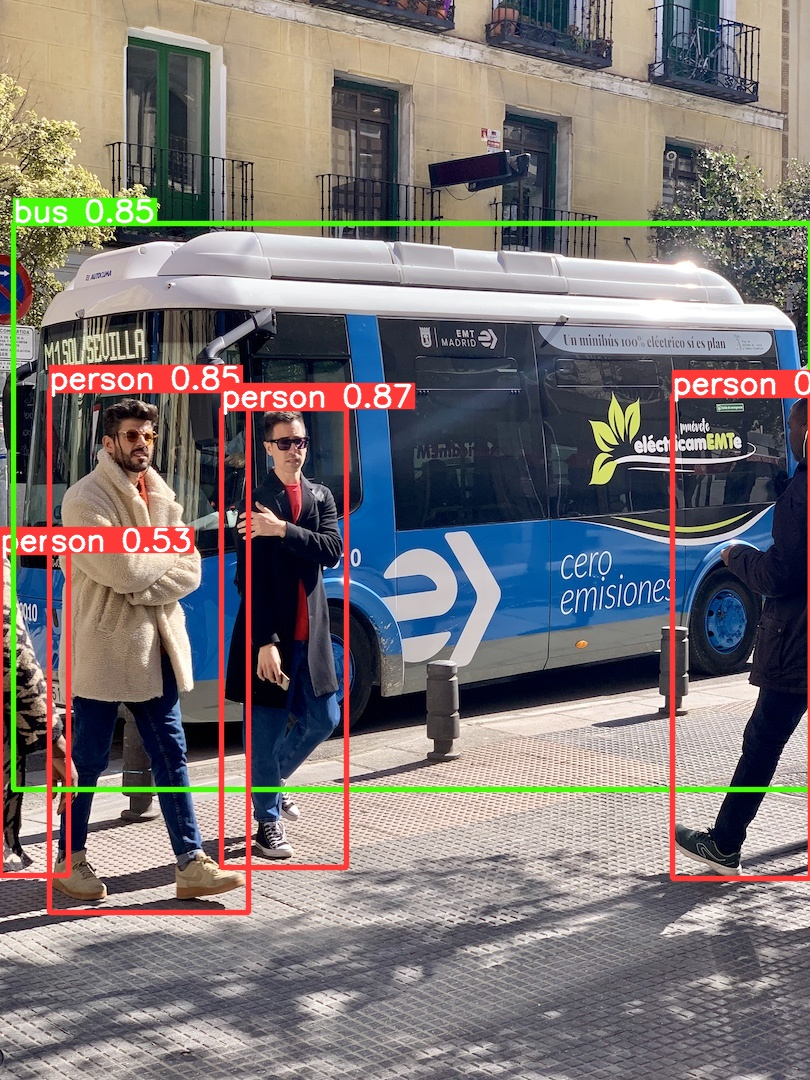

In [6]:
from IPython.display import Image
Image('yolov5/runs/detect/exp/bus.jpg')

## YOLO v1 모델

Object Detection의 대표적인 모델이며, 두 문제를 하나로 통합하여 regression 문제로 해결합니다.
- Bounding Box(bbox) Regression
- Class Classification

<br>이제부터는 YOLO 모델이 어떻게 만들어졌는지, 버전 별로 어떤 발전과 기여(contribution) 했는지를 알아봅시다. 

- Basic 모델과 Fast 모델로 구성되어 있습니다.
- Basic 모델은 45 Frames per second
- Fast 모델은 155 Frames per second

###Method

#### All bbox, all classes

- 이미지를 7x7의 그리드(grid)로 나눠줍니다.
- 그리드 셀의 중심 좌표 $(x, y)$와 크기 $(w, h)$ 그리고 confidence score를 입력한 5개의 벡터를 만들어줍니다.
- Class 정보를 담고있는 20개의 벡터를 덧붙여줍니다.
- 총 2개의 후보박스와 20개의 벡터를 하나로 묶어서, 30개 벡터를 예측하는 문제를 풀게 됩니다.

 <img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v1_grid.jpeg">



#### Network Design

- 네트워크의 디자인은 시간관계상 자세히 보지는 않겠습니다. 
- Fast모델과 Basic 모델의 차이는 3번째 Conv Layer부터 1x1, 3x3 conv 레이어와 채널 수의 차이가 있다는 점만 주목해서 보시면 되겠습니다. 

 - 출력 : $7 \times 7 \times 30$ 

- 앞서 All bbox, all classes 부분에서 설명한 것처럼 7x7 그리고 30개의 벡터로 이루어진 출력을 보실 수 있습니다.

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v1_architecture.png">

#### Pre-Trained Model 활용

 - ImageNet의 1000개 Class를 구분했던 모델의 앞부분을 활용해서, Feature Extraction 모델로 활용합니다. 최초 20개의 레이어를 재사용하고, 훈련은 ImageNet 2012 validation set을 이용해서 top-5 error가 88%될때까지 진행한 모델입니다.

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v1_architecture_2.png">

#### Loss Function

- 논문의 Loss를 그대로 가져왔습니다. 
- x, y는 바운딩 박스에서 가져왔고, $\lambda_{coord}$ 로는 5를 사용했습니다. 
- w, h는 바운딩 박스의 크기를 나타냅니다. square root가 사용된 것은 박스 크기가 작을 수록 더 많은 패널티를 가져가도록 구성되었습니다.
- Confidence는 Object가 있는 곳과 없는 곳을 차등적용하기 위해서 계수를 적용하였고, 논문에서는 $\lambda_{noobj}$로 0.5를 사용하였습니다.
<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v1_lossf.png" width = 800>


### 실험 결과 (평가지표 : mAP, FPS)

- [mean Average Precision](https://www.v7labs.com/blog/mean-average-precision#h1)
- Frames per second

  <img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v1_table1.png" width = 500>


<br>🚀 YOLO의 핵심은 **<font color="ff6f61">속도</font>**에 있습니다.  
<br>
FPS를 보면 정말 기존 모델과는 확연한 차이를 나타내는 것을 볼 수 있습니다. <br> mAP를 보면 아무래도 2-stage 모델에 비해서 다소 부족한 것을 볼 수 있는데요, <br>이후 모델들을 통해서 이런 성능의 한계점들을 어떻게 개선해 나갔는지 배워보시죠!

##YOLO v2

- YOLO v2는 논문 이름이 많은 것들을 나타내주는데요, **"YOLO9000: Better, Faster, Stronger"** 이란 이름으로 퍼블리시 되었습니다.
- 9000은 뭘까요? 9000개의 Class를 다뤘을까요?
- Better, Faster, Stronger는 아마 뭔가 더 좋고, 빠르고, 강화된 것을 보여주는 것 같습니다. 차근차근 한번 알아볼까요?

### Better


YOLO v1과의 차이를 한번 봅시다.

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v2_table1.png">

각각의 체크 표시가 기존의 YOLO를 강화하기 위해서 추가한 옵션들이라고 생각하시면 되겠습니다.

#### 1. Batch Normalization

<br>
<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v2_batchnorm.png" width =500>

컴퓨터의 메모리 때문에 우리는 모든 데이터를 한번에 넣을 수가 없습니다.  
그래서 mini-batch 방식을 활용해서 Mnist 샘플 튜토리얼에서는 이미지를 100장 씩 넣어주었죠.  
일반적으로는 2의 제곱 수에 맞춰서 64장, 128장 등 단위로 batch_size를 선정해서 학습을 진행합니다. 

<br>데이터가 batch단위로 따로따로 들어올 때, 이때 각 데이터 그룹간의 '차이'를 줄이고자 batch별로 정규화를 진행해주는 것을 **batchnorm**이라고 배웠습니다.  
이미지에서 어떻게 구현하는 것인지 수식을 통해서 배울 수 있습니다. 

<br>배치 정규화의 장단점은 여기서 다루지 않겠습니다. 
Yolo v2 모델에서는 배치정규화를 도입하면서 mAP가 약 4% 가량 증가한 것을 볼 수 있습니다.

#### 2. High Resolution Classifier


- Yolo에서 ImageNet을 이용해서 Pre-train을 한 뒤에 사용한다는 것을 배웠습니다. 이 때, ImageNet의 원본 이미지는 224x224 형태로 구성된 데이터 셋을 이용합니다.
- Yolo v2모델에서는 이 모델을 448x448 이미지로 Fine-tuning해서 사용합니다. 
- 총 10 epoch만큼 추가로 학습시키고, 모델의 Output은 416x416으로 나오도록 설정합니다.
-  Yolo v2의 최종 출력을 홀수개로 맞춰야, 대부분의 데이터셋이 중앙부에 객체들이 있기 때문에 이렇게 설정해주었다고 합니다.

#### 3. Convolutional with anchor boxes

- 아키텍쳐의 변형을 가한 부분입니다. 
- yolo 모델에서는 FC layer 이후에 다시 7x7x30의 형태로 모델을 변경해주었는데, 해당 FC layer를 모두 제거합니다. 
- bbox를 예측할 때, RCNN와 Yolo의 차이가 anchor 박스의 사용 유무도 있었는데, v2부터는 anchor 박스를 사용합니다. 
- 앵커 박스의 위치(offsets)와 confidences 값을 예측하는 RPN을 활용합니다. RCNN에서 다뤄지는 내용이라서, 이런 것이 추가로 사용된다 정도로만 설명하고 넘어가겠습니다. 좌표 대신 Offset을 예측하는 문제로 단순화되어 학습을 조금 더 쉽게 할 수 있도록 합니다.
- 여기서는 특이하게 anchor 박스를 도입하여 성능(mAP)이 다소 감소하는 것을 확인할 수 있다. 그러나 Recall이 증가하기 때문에 사용하는 것이 좋다고 합니다.

#### 4. Dimension Clusters

- anchor박스를 도입할 때, R-CNN에서 사람이 직접 offset을 설정했다고 하는데, 그 설정 방식을 clustering 방식으로 바꾼다는 개념입니다.
- K-means clustering을 쓸때, 유클리디안 거리를 사용하게 되면 큰 박스에서 오차가 더 크게 됩니다. 
- 따라서 박스 크기와 상관없는 IOU개념을 도입하여 클러스터링의 기준을 삼아줍니다. 
- 이 부분이 이해하기 어려운 부분이라 논문에 없는 그림을 찾아서 첨부해두었습니다.

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v2_DimensionCluster.png">


#### 5. Direct location prediction


- Anchor box의 중심점의 좌표($t_x, t_y$)를 결정할 때 sigmoid function을 적용하여 Grid cell 내에 중심이 위치하도록 합니다.
- Faster RCNN에서는 이 거리의 제약이 없어서, 그리드(grid)를 벗어나는 anchor box가 생성이 되는 문제가 있었습니다.

#### 6. Fine-grained features


- 아키텍쳐 모양을 얼핏 ResNet에서 배웠던 Skipped-connection과 비슷하게 보입니다. 
- 26x26x512 feature map을 4개로 쪼개면, 13x13x512x4개가 생기는데, 이를 concat해서 길게 늘이는 방식입니다.
- 다음 layer의 출력과 이렇게 만들어진 특징을 concat하면 13x13x(1024+2048) 형태로 만들어집니다.
- 이해를 돕기위해서 논문에 없는 이미지를 첨부합니다.

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v2_architecture.jpeg"> (출처 : https://velog.io/@mindy1147/YOLO9000-Paper)



#### 7. Multi-Scale Training

- yolo v2에서는 448x448 이미지로 추가 학습하였고, 출력값의 홀수화를 위해서 416x416으로 다시 입력을 변경하였다는 것에 대해서 이전에 설명합니다.   
- 여기서는 batch마다 이 입력값의 사이즈를 다르게 넣어주는 것을 의미합니다. 320x320 부터 시작하여 608x608까지 조절하며 스케일(scale)을 여러가지로 학습을 시켜주는 방식입니다.
- 10번의 배치마다 랜덤하게 새로운 해상도로 선택하여 학습을 진행합니다. 
- 해상도마다 성능을 다르게 기록되었습니다.
- 당연한 일이지만, 해상도를 높이면 처리 속도가 감소합니다.
- 실험 결과 테이블을 추가로 첨부합니다.  
<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v2_table3.png" width=500>

### Faster - DarkNet-19

- VGG-16만큼 정확하면서, GoogLeNet처럼 빠른 CNN을 구현하였다.
- VGG의 경우 파라미터의 수가 너무 많다는 것, 따라서 19개의 Conv와 5개의 Pooling 레이어로 구성한다.  
<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v2_darknet19.png" width=500>

### Stronger - Hierarchical Classification

- ImageNet 의 label은 WordNet 기반으로 구성되어 있습니다. (Tree 구조형태가 아님)
- 구조화된 분류 학습을 통해서 Word Tree를 만들어서, 공통의 뿌리를 갖는 Class들을 만들어냅니다.
 - Norfolk terrier
 - Yorkshire terrier
 - Bedlington terrier
- 같은 맥락끼리 묶어낸다고 생각하시면 되겠습니다. 첨부된 이미지를 통해서 조금 더 자세히 알아봅시다!   <img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v2_wordtree.png" width=800>
- 이렇게 9000개의 클래스로 확장해서 학습을 시키고 실험이 진행 되었습니다.
- 동물들은 잘 구분했지만, clothing, equipment 관련된 것들은 성능이 좋지 않았다고 합니다. 

자신이 선택한 도메인에서, 적어도 어떤 모델들이 어떻게 발전했는 지 나만의 History를 그릴 수 있어야 합니다.

## YOLO v3




- 저자가 말하길, YOLO v3는 다른 사람들이 제시한 좋은 아이디어들을 취한 버전이라고 말합니다. 일부 실험 테이블은 다른 논문에서 그대로 차용했다고 설명하기도 합니다. 
- 이후 버전 yolo v4, v5, v6, v7의 경우는 동일 저자의 논문이 아닙니다. 
- v2의 Bounding Box Prediction 을 활용하고, softmax를 사용하지 않고, independent logistic classifiers를 활용하여 분류를 수행합니다.
- v2에서는 여러가지 Scale을 활용했다면, v3에서는 3 가지의 scale만을 활용합니다.
- Box는 3개를 활용하며, 80개의 클래스를 다룹니다.
  - $N \times N \times 3 \times (4+1+80)$

- Darknet-53을 활용하여 ResNet-101, ResNet-152보다 좋은 성능을 나타냅니다.

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v3_backbone.png"> 

- 다른 실험들에서 참조한 성능을 비교해서 시각화하였습니다. 

<img src="https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/ObjectDetection/yolo_v3_results.png"> 



## YOLO v3 vs. YOLO v5

앞선 내용에서 v3 까지만 살펴보았지만, 예제에서는 v5 를 불러와 사용했습니다.  
때문에 v3와 v5는 구조적으로 어떤 차이가 존재하는지, 성능에는 어떤 차이가 존재하는지 알아보겠습니다.

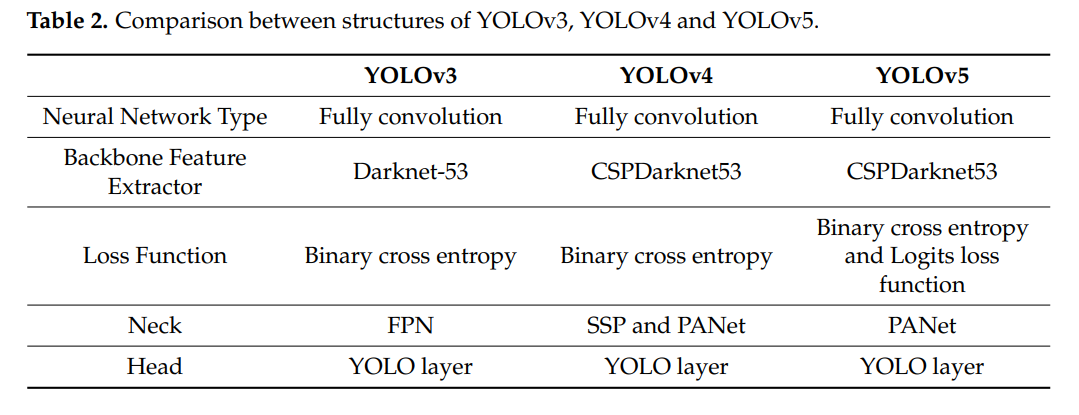

- Backbone을 Darknet-53에서 CSPDarknet-53으로 변경하였습니다.
- Neck을 FPN에서 PANet으로 변경하었습니다.

<br>이외에 v4에서 개발 목적(정확도 향상)을 달성하기 위해 data augmentation과 같은 곳에서 여러 최신 기법이 적용되고,  
v5에서 프레임워크를 C언어 기반의 Darknet에서 PyTorch로 변경하는 등의 많은 변화가 있었습니다.  
하지만 시간관계상 Neck과 Backbone의 차이만 알아보겠습니다.

###CSPNet (Cross Stage Partial Net)

작은 객체를 잘 예측하기 위해 Input Image를 크게 사용하며, 큰 수용 영역의 receptive field를 위해 layer를 깊게 쌓고,  
모델의 성능을 위해 많은 parameter 수를 가지고, 동시에 빠른 inference 속도를 가져야합니다.

<br>다시 말해 Layer도 깊고, parameter 개수도 많은데, 속도는 빨라야 합니다.  
이를 만족하기 위해 v4부터 Backbone으로 CSPDarknet53을 채택했습니다.

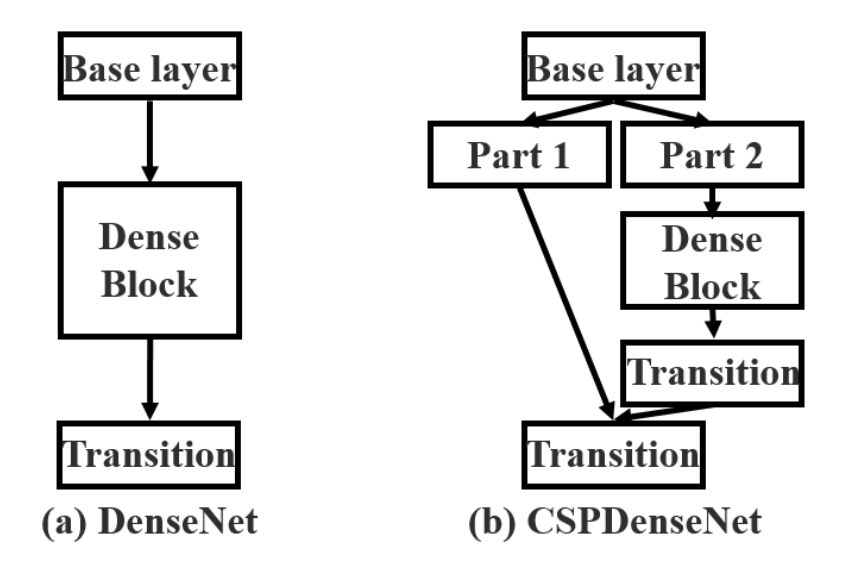

CSPNet는 빠른 연산 속도를 위해 input feature map을 두 part로 나누어 한 part에서는 아무 연산도 하지 않고 전달만 하고, 다른 한 part만 연산하여 이 둘을 합쳐(concat)주게 됩니다.  
이렇게 하면 정확도는 해치지 않으면서 빠른 연산이 가능하게 됩니다. 

###PANet (Path Augmented Network)

일반적으로 층이 깊어질수록 물체의 경계에서 전체적인 윤곽을 학습하게 됩니다. (N431 참고)  
Object Detection에서는 더 정확한 localization을 위해 얕은 층의 정보와 깊은 층의 정보를 둘 다 활용하게 됩니다.  

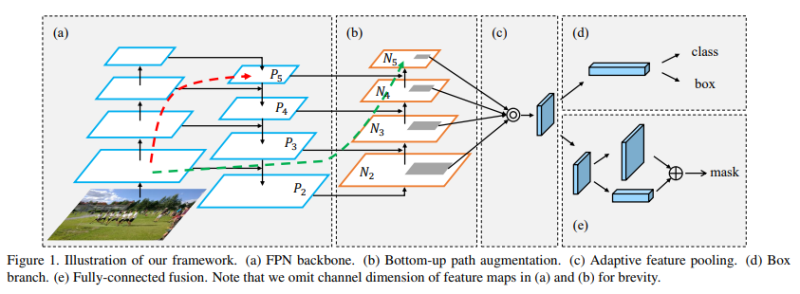

기존의 FPN에서는 하단의 Layer가 상단까지 도달하기 위해 엄청나게 많은 Layer를 거쳐야합니다. (빨간색 점선)  
이것이 비효율적이기 때문에 PANet에서는 FPN에서 생성한 $[P_2, \, P_3, \, P_4, \,  P_5]$을 이용해 $[N_2, \, N_3, \, N_4, \, N_5]$를 생성하여 얕은 층에서 학습한 정보가 깊은 층으로 갈 때, 몇 개의 Layer만 거치게 만들어 줬습니다. (초록색 점선)

### 성능 비교

v3, v4, v5의 성능을 시각화하였습니다.  
v5가 v3에 비해 같은 시간에 더 높은 정확도를 보이고 있습니다.

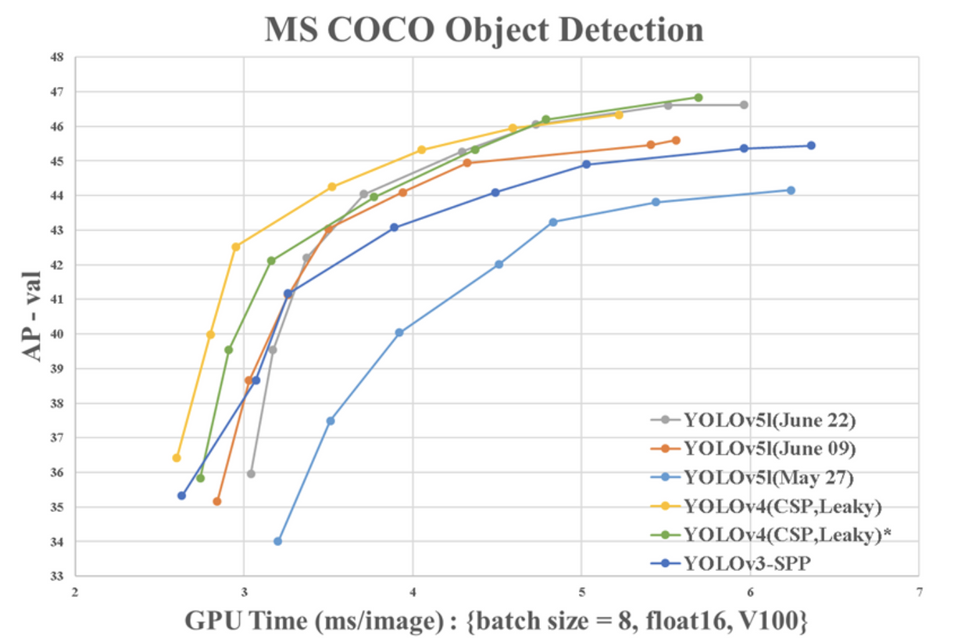

# 마무리.
 Yolo 논문 2편을 정독했고, 3편까지의 저자의 연구, v3와 v5의 구조적인 차이와 성능으로 마무리되고 있습니다.  
 각 논문 사이사이에 여러가지 연구가 있었고, 각각은 특별한 기능들을 개선하는데 사용된 방법들이 있었습니다.  


가장 중요한 것은 **목적에 맞는 모델을 잘 활용하는 것입니다.**

<br>이 외에도 YOLO에 대해 더 자세하게 알고 싶다면 아래 링크에서 확인해볼 수 있습니다.  
https://github.com/AlexeyAB/darknet  
https://github.com/ultralytics/yolov3  
https://github.com/ultralytics/yolov5  
<br>위 링크에서 result(inference speed)를 확인하는 방법이나 custom training 진행 방법 등을 확인할 수 있습니다.  
또한 모델의 architecture 및 앞서 언급한 모델에 적용된 다양한 data augmentation 등에 대한 내용도 담겨있습니다. (https://github.com/ultralytics/yolov5/issues/6998)  


---
## Reference

- https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf
- https://arxiv.org/pdf/1612.08242.pdf
- https://arxiv.org/pdf/1804.02767.pdf
- https://velog.io/@skhim520/YOLO-v2-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0
- https://velog.io/@mindy1147/YOLO9000-Paper
- https://www.youtube.com/watch?v=vLdrI8NCFMs
- https://www.mdpi.com/1424-8220/22/2/464
